# 1.**文献总结**
***Human 5’ UTR Design and Variant Effect Prediction from a Massively Parallel Translation Assay***
## **(1)实验设计与数据收集**
文章构建了一个包含280,000个随机5' UTR序列的库，每个序列长度为50个核苷酸，紧接着是增强绿色荧光蛋白（eGFP）的编码序列（CDS）和3' UTR。通过多核糖体分析技术，测量了每个5' UTR序列的核糖体负载量（MRL），即每个mRNA上结合的核糖体数量，并结合RNA测序（RNA-seq）获得了每个序列在多核糖体各组分中的分布，从而为后续模型训练提供了高质量的数据基础。
## **(2)深度学习模型搭建**
### 卷积神经网络（CNN）架构
文章使用卷积神经网络（CNN）来预测5' UTR序列的核糖体负载量（MRL）。模型的输入是5' UTR序列的one-hot编码，输出是预测的MRL值。
- **卷积层**：模型包含三个卷积层，每个卷积层使用不同数量的滤波器（filters）来捕捉序列中的局部特征。第一层卷积层有120个滤波器，第二层和第三层卷积层也有120个滤波器。
- **全连接层**：卷积层之后是一个全连接层（dense layer），包含40个节点，并使用20%的dropout来防止过拟合。
- **输出层**：模型的输出层是一个线性输出，用于预测MRL值。
### 模型训练与验证
模型使用260,000个5' UTR序列进行训练，剩余的20,000个序列用于测试。通过网格搜索（grid search）优化超参数，最终模型在测试集上能够解释93%的MRL变异。
## **(3) 模型扩展与应用**
文章扩展了模型的应用范围，构建了一个能够预测完整多核糖体分布的模型，输出层包含14个线性输出，分别对应多核糖体的14个组分。此外，模型在含有假尿苷（Ψ）和1-甲基假尿苷（mΨ）的化学修饰RNA上也表现出色，能够解释其翻译效率变化。通过结合遗传算法和Optimus 5-Prime模型，研究人员成功设计了新的5' UTR序列，能够精确控制蛋白质表达水平。
## **(4)人类5' UTR变异的预测**
在人类5' UTR变异预测方面，模型测试了35,212个人类5' UTR序列和3,577个自然变异，解释了82%的核糖体负载量（MRL）变异，并成功预测了45个疾病相关单核苷酸变异（SNVs）对翻译的影响。模型还通过扩展输入层宽度，能够处理25到100个核苷酸长度的5' UTR序列，展示了其在更广泛序列长度范围内的预测能力。

# 2. **DNABERT-CNN Model**

## **(1) Pre_Trained DNABERT Model**

 首先调用预训练的DNABERT模型，并将其用于提取5' UTR序列的特征提取，用于下游CNN进行回归分析。

In [ ]:
from transformers import AutoTokenizer, AutoModel, BertConfig
import torch

# 加载本地模型
model_path = "/data2404/buyf/Class/ai4bio/hw5/zhihan1996/DNABERT-2-117M"

# 手动指定config_class
config = BertConfig.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
model = AutoModel.from_pretrained(model_path, config=config, trust_remote_code=True)

In [29]:
# 将模型设置为评估模式
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(4096, 768, padding_idx=0)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertUnpadAttention(
          (self): BertUnpadSelfAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (Wqkv): Linear(in_features=768, out_features=2304, bias=True)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (mlp): BertGatedLinearUnitMLP(
          (gated_layers): Linear(in_features=768, out_features=6144, bias=False)
          (act): GELU(approximate='none')
  

DNABERT 是一种基于 **BERT（Bidirectional Encoder Representations from Transformers）** 架构的预训练模型，专门设计用于处理 **DNA 序列数据**。它通过在大规模 DNA 序列数据上进行预训练，学习 DNA 序列的上下文表示，从而能够捕捉 DNA 序列中的生物学特征和模式：

**模型架构**：DNABERT 基于标准的 BERT 架构，但针对 DNA 序列数据进行了调整和优化。其主要组成部分包括：
**(1) Embedding 层**
- **Word Embeddings**：将 DNA 序列中的每个核苷酸（A、T、C、G）映射为一个高维向量（如 768 维）。
- **Position Embeddings**：为序列中的每个位置添加位置信息，帮助模型理解序列的顺序。
- **Token Type Embeddings**：在 BERT 中用于区分不同句子，但在 DNABERT 中通常不使用。
**(2) Transformer Encoder**
- 由多个 Transformer 层（如 12 层）组成，每层包含：
  - **Self-Attention 机制**：捕捉序列中不同位置之间的依赖关系。
  - **Feed-Forward Network（FFN）**：对每个位置的特征进行非线性变换。
**(3) Pooler 层**
- 用于将整个序列的表示汇总为一个固定长度的向量（如 768 维），通常用于下游任务。

**输入** :DNA 序列被分割为固定长度的片段;每个核苷酸被映射为一个 token，输入到模型中。

**输出**:DNABERT 的输出是每个位置的隐藏状态（`last_hidden_state`），形状为 `[batch_size, sequence_length, hidden_size]`,通过池化（如最大池化或均值池化）将整个序列的表示汇总为一个固定长度的向量。

In [44]:
import numpy as np

def extract_dnabert_features(sequences, tokenizer, model, max_length=50):
    """
    提取DNABERT的特征
    :param sequences: 5' UTR序列列表
    :param tokenizer: DNABERT的tokenizer
    :param model: DNABERT模型
    :param max_length: 序列的最大长度（DNABERT通常支持512个token）
    :return: 提取的特征（numpy数组）
    """
    features = []
    for seq in sequences:
        # Tokenize序列
        inputs = tokenizer(seq, return_tensors="pt", max_length=max_length, padding="max_length", truncation=True)
        
        # 提取隐藏状态
        with torch.no_grad():
            outputs = model(**inputs)
            hidden_states = outputs[0]  # 假设第一个元素是last_hidden_state
        
        # 使用最大池化提取特征
        embedding_max = torch.max(hidden_states[0], dim=0)[0]  # 最大池化
        features.append(embedding_max.numpy())
    
    return np.array(features)

## **(2) Data Processing**

In [19]:
import pandas as pd
# 加载训练集和测试集
train_data = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")

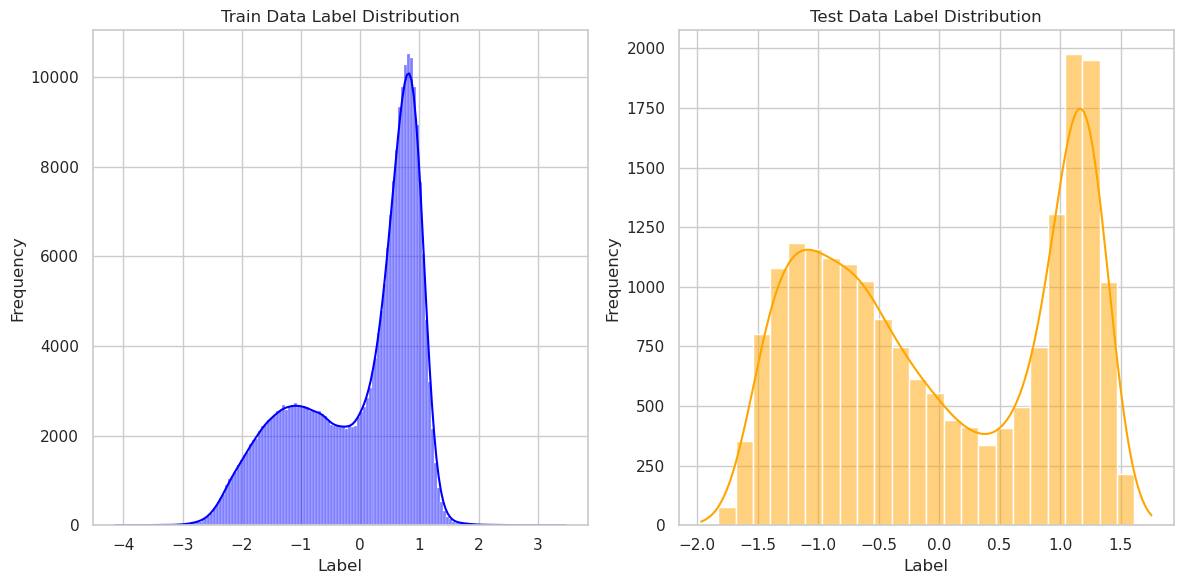

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置绘图风格
sns.set(style="whitegrid")

# 绘制训练集和测试集的label分布
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(train_data["label"], kde=True, color="blue")
plt.title("Train Data Label Distribution")
plt.xlabel("Label")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.histplot(test_data["label"], kde=True, color="orange")
plt.title("Test Data Label Distribution")
plt.xlabel("Label")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

从图表中可以看出，训练集和测试集的标签（`label`）分布较为相似，主要集中在-2到1之间，呈现出近似正态分布的趋势。训练集的标签分布范围稍广，而测试集的标签分布相对集中，数据集的标签分布较为均衡，适合用于回归任务。

In [38]:
# 提取训练集和测试集的特征
train_sequences = train_data["seq"].tolist()
test_sequences = test_data["seq"].tolist()

In [45]:
#这一步骤耗时约一个半小时
train_features = extract_dnabert_features(train_sequences, tokenizer, model)
test_features = extract_dnabert_features(test_sequences, tokenizer, model)

In [46]:
# 保存标签
train_labels = train_data["label"].values
test_labels = test_data["label"].values

In [47]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# 将特征和标签转换为PyTorch张量
train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)

# 创建数据集
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)

# 创建数据加载器
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [69]:
# 将张量保存为字典
data = {
    "train_features": train_features_tensor,
    "train_labels": train_labels_tensor,
    "test_features": test_features_tensor,
    "test_labels": test_labels_tensor
}

# 保存字典到文件
torch.save(data, "data_tensors.pt")

## **(3) CNN Model**

In [132]:
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super(CNNModel, self).__init__()
        # 第一层卷积：120 个滤波器，卷积核大小为 8，步幅为 4
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=120, kernel_size=8, stride=4)
        # 第一层BatchNorm
        self.bn1 = nn.BatchNorm1d(120)
        
        # 第二层卷积：120 个滤波器，卷积核大小为 8，步幅为 1
        self.conv2 = nn.Conv1d(in_channels=120, out_channels=120, kernel_size=8, stride=1)
        # 第二层BatchNorm
        self.bn2 = nn.BatchNorm1d(120)
        
        # 第三层卷积：120 个滤波器，卷积核大小为 8，步幅为 1
        self.conv3 = nn.Conv1d(in_channels=120, out_channels=120, kernel_size=8, stride=1)
        # 第三层BatchNorm
        self.bn3 = nn.BatchNorm1d(120)
        
        # 全连接层：输入维度为 120，输出维度为 40
        self.fc1 = nn.Linear(120, 40)
        # 输出层：输入维度为 40，输出维度为 1
        self.fc2 = nn.Linear(40, output_dim)
        
        # Dropout层
        self.dropout_conv = nn.Dropout(0.2)  # 卷积层后的 Dropout
        self.dropout_fc = nn.Dropout(0.5)    # 全连接层后的 Dropout
    
    def forward(self, x):
        # 输入 x 的形状: (batch_size, input_dim, seq_len)
        
        # 第一层卷积 + Batch Normalization + ReLU 激活 + Dropout
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout_conv(x)
        
        # 第二层卷积 + Batch Normalization + ReLU 激活 + Dropout
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout_conv(x)
        
        # 第三层卷积 + Batch Normalization + ReLU 激活 + Dropout
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout_conv(x)
        
        # 全局平均池化，将特征图压缩为 1 维
        x = F.adaptive_avg_pool1d(x, 1).squeeze()
        
        # 全连接层 + ReLU 激活 + Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        
        # 输出层
        x = self.fc2(x)
        return x

如果直接采用原文献中的CNN模型会导致训练过程中loss波动较大，因此在原文献中的CNN模型上加上Batch Normalization层后训练过程稳定下降。同时在训练过程中发现有比较严重的过拟合现象，因此在卷积层也加入dropout层，缓解过拟合现象。

## **(3) Train and Test Model**

In [138]:
# 初始化CNN模型
input_dim = 1 # DNABERT特征的维度
cnn_model = CNNModel(input_dim= input_dim)

In [139]:
import torch.optim as optim

# 定义损失函数和优化器
criterion = nn.MSELoss()  # 回归任务使用均方误差损失
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001,weight_decay=1e-5)
# 定义学习率调度器
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

In [140]:
num_epochs = 20
patience = 3  # 设置 patience，表示在连续多少个 epoch 没有改善时停止训练
best_loss = float('inf')  # 初始时设置一个非常大的损失值
patience_counter = 0  # 用于计数连续多少个 epoch 没有改善
epsilon = 0.01

In [141]:
import csv

# 记录损失的列表
loss_log = []

# 设置日志文件路径
log_file = 'training_loss_log3.csv'

# 打开并创建日志文件，添加标题
with open(log_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Loss'])  # 写入标题

In [142]:
# 训练过程
for epoch in range(num_epochs):
    cnn_model.train()
    
    running_loss = 0.0  # 累积当前 epoch 的损失
    for batch_features, batch_labels in train_dataloader:
        # 前向传播
        batch_features = batch_features.unsqueeze(1)  
        outputs = cnn_model(batch_features)
        loss = criterion(outputs.squeeze(), batch_labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 累加损失
        running_loss += loss.item()
    
    # 平均损失
    avg_loss = running_loss / len(train_dataloader)
    
    # 输出当前 epoch 的损失
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    
    # 记录损失到日志文件
    with open(log_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch+1, avg_loss])  # 记录当前 epoch 的损失
    
    # 记录损失到列表
    loss_log.append((epoch + 1, avg_loss))
    
    # 检查损失是否改进，如果没有，则增加 patience_counter
    if best_loss - avg_loss  < epsilon:
        best_loss = avg_loss  # 更新最佳损失
        patience_counter = 0  # 重置计数器
    else:
        patience_counter += 1  # 增加计数器
    
    # 如果损失没有改善超过 patience 次，停止训练
    if patience_counter >= patience:
        print(f"Early stopping after {epoch+1} epochs.")
        break
    
    # 在每个 epoch 结束时调用学习率调度器
    scheduler.step(avg_loss) 

Epoch [1/20], Loss: 0.9415
Epoch [2/20], Loss: 0.8972
Epoch [3/20], Loss: 0.8822
Epoch [4/20], Loss: 0.8697
Epoch [5/20], Loss: 0.8613
Epoch [6/20], Loss: 0.8548
Epoch [7/20], Loss: 0.8518
Epoch [8/20], Loss: 0.8461
Epoch [9/20], Loss: 0.8437
Epoch [10/20], Loss: 0.8409
Epoch [11/20], Loss: 0.8377
Epoch [12/20], Loss: 0.8335
Epoch [13/20], Loss: 0.8308
Epoch [14/20], Loss: 0.8275
Epoch [15/20], Loss: 0.8253
Epoch [16/20], Loss: 0.8250
Epoch [17/20], Loss: 0.8221
Epoch [18/20], Loss: 0.8204
Epoch [19/20], Loss: 0.8188
Epoch [20/20], Loss: 0.8181


<Axes: title={'center': 'Training Loss Curve'}, xlabel='Epoch'>

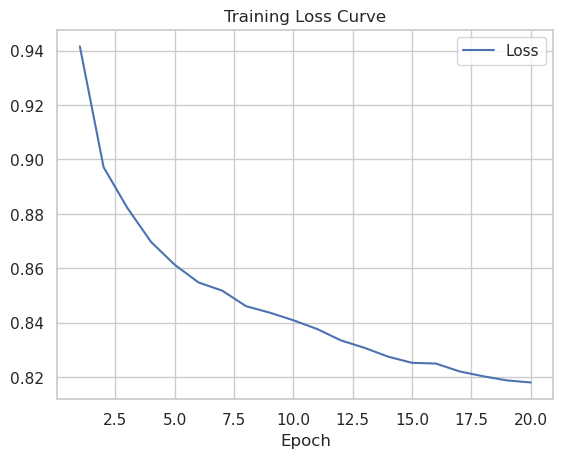

In [143]:
# 训练完成后，你可以进一步查看日志文件 `training_loss_log.csv`.
import pandas as pd
log_df = pd.read_csv(log_file)
log_df.plot(x='Epoch', y='Loss', title='Training Loss Curve')

可以看到随着Epoch进行，loss逐渐稳定下降，且下降的幅度越来越小。为了防止模型过拟合，进行20个Epoch后停止训练。

In [146]:
from sklearn.metrics import r2_score
# 定义损失函数
criterion = nn.MSELoss()  # 回归任务使用均方误差损失

# 将模型设置为评估模式
cnn_model.eval()

# 存储真实值和预测值
true_labels = []
predictions = []

# 存储总损失
total_loss = 0.0

# 禁用梯度计算
with torch.no_grad():
    for batch_features, batch_labels in test_dataloader:
        # 前向传播
        batch_features = batch_features.unsqueeze(1)  # 如果需要增加维度
        outputs = cnn_model(batch_features)
        
        # 计算损失
        loss = criterion(outputs.squeeze(), batch_labels)
        total_loss += loss.item()  # 累加每个批次的损失
        
        # 将结果存储到列表中
        true_labels.extend(batch_labels.numpy())
        predictions.extend(outputs.squeeze().numpy())

# 计算平均损失
average_loss = total_loss / len(test_dataloader)
print(f"Test Loss: {average_loss:.4f}")
r2 = r2_score(true_labels, predictions)
print(f"R^2 Score: {r2:.4f}")

Test Loss: 0.7860
R^2 Score: 0.2142


Test.loss未发生明显的下降，推测模型发生了过拟合现象，因此在原本的模型上在卷积层上加入dropout层，同时加入L2正则化项和早停（training loss）不再下降就停止训练，有效的缓解了过拟合现象。但是模型的loss依旧比较高，预测的label和真实label之间的R^2比较低，可能由于首先采用 DNABERT 进行embedding，对于后续的1D CNN提取局部特征不合适，原文献中采用K-mer进行分词和embedding的方式对于下游的1D CNN提取局部特征可能更加合适!